# This notebook contains code for our first attempt at TCN with PyTorch, was not able to get it to work...

In [19]:
import random

import numpy as np
import pandas as pd
from pytorch_tcn import TCN
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("dataset.csv")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



In [20]:

pd.options.display.max_rows = 999
count_by_sec_and_mrc = df.groupby(["sector", "mrc"]).count().unstack().tavg.T.reset_index()

for i, row in count_by_sec_and_mrc.iterrows():
    mrc = row["mrc"]
    row = row.drop("mrc")
    if (row == 96).all():
        pass
    else:
        print(mrc)
        print((row == 96))


def remove_incomplete_mrc_sectors(df):
    unwanted_mrc_sectors = [
        ("Administration régionale Kativik", "AGRICOLE"),
        ("Administration régionale Kativik", "INDUSTRIEL"),
        ("Caniapiscau", "AGRICOLE"),
        ("Le Golfe-du-Saint-Laurent", "AGRICOLE")
    ]

    for mrc, sector in unwanted_mrc_sectors:
        df = df[~((df["mrc"] == mrc) & (df["sector"] == sector))]


    return df

df = remove_incomplete_mrc_sectors(df)
df["sector_mrc"] = df["sector"] + df["mrc"]
sector_mrcs = df["sector_mrc"].unique()


Administration régionale Kativik
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL        False
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 3, dtype: bool
Caniapiscau
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL         True
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 15, dtype: bool
Le Golfe-du-Saint-Laurent
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL         True
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 45, dtype: bool


In [21]:
def preprocess(df):
    new_df = pd.DataFrame()
    for sector_mrc in sector_mrcs:
        sector_mrc_df = df[df["sector_mrc"] == sector_mrc].sort_index()
        sector_mrc_df["total_kwh"] = sector_mrc_df["total_kwh"].interpolate(method="index")

        new_df = pd.concat([new_df, sector_mrc_df])

    return new_df
df = preprocess(df)

df = df.set_index(pd.to_datetime(df.date, format="%Y-%m-%d")).sort_index()



train_df = df["2016":"2021"]
validation_df = df["2022":"2022"]
test_df = df["2023":]
df = df.drop(columns=["date"])
df = df.sort_values(["mrc", "sector", "date"])


# df = torch.tensor(df).float()


# kwh_scaler = StandardScaler()
# temp_scaler = StandardScaler()
# df["total_kwh"] = kwh_scaler.fit_transform(df[["total_kwh"]])
# df["tavg"] = temp_scaler.fit_transform(df[["tavg"]])

In [4]:
print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(31392, 6)
(5232, 6)
(5232, 6)


In [ ]:
def get_sequence(df: pd.DataFrame, sector_mrc: str):
    """Get a sequence of total_kwh and tavg for a given sector_mrc"""

    # print(mrc)
    sequence = df[df.sector_mrc == sector_mrc]
    sequence = sequence[["total_kwh", "tavg"]]

    # Scale the data
    kwh_scaler = StandardScaler()
    temp_scaler = StandardScaler()
    sequence[['total_kwh']] = kwh_scaler.fit_transform(sequence[['total_kwh']])
    sequence[['tavg']] = temp_scaler.fit_transform(sequence[['tavg']])
    
    # Difffff
    starting_level = sequence["total_kwh"].iloc[0]
    sequence["total_kwh"] = sequence["total_kwh"].diff()


    # Make sector categorical variables

    # Label is the next total_kwh
    sequence["label"] = sequence.total_kwh.shift(-1)

    # Drop the last row
    sequence = sequence.dropna()


    sequence = sequence[["total_kwh", "tavg", "label"]]
    sequence = torch.tensor(sequence.values).float()

    # print(sequence.shape)

    return sequence, kwh_scaler, temp_scaler, starting_level


def get_n_sequences(sector_mrc: list[str], train=True, test=False):
    """Get a tensor of sequences for a list of sector_mrcs"""
    if train:
        df = train_df
    elif test:
        df = test_df
    else:
        df = validation_df

    sequences = []
    kwh_scalers = []
    temp_scalers = []
    consumptions = []
    for sector_mrc in sector_mrc:
        sequence, kwh_scaler, temp_scaler, starting_level = get_sequence(df, sector_mrc)
        sequences.append(sequence)
        kwh_scalers.append(kwh_scaler)
        temp_scalers.append(temp_scaler)
        consumptions.append(starting_level)


    stacked = torch.stack(sequences)
    return stacked, kwh_scalers, temp_scalers, consumptions

@torch.inference_mode()
def validate(model):
    mapes = []
    rmses = []
    model = model.eval()
    with torch.no_grad():
        for sector_mrc in sector_mrcs:
            batch, kwh_scaler, temp_scaler, starting_levels = get_n_sequences([sector_mrc], train=False)
            starting_levels = torch.tensor(starting_levels).float().unsqueeze(1)

            batch = batch.permute(0, 2, 1)
            X = batch[:, :-1, :]
            y = batch[:, -1, :]
            y = torch.cat((starting_levels, y), dim=1).cumsum(dim=1)[:, 1:]

            output = model(X)
            output = torch.cat((starting_levels, output.squeeze(1)), dim=1).cumsum(dim=1)[:, 1:]

            # y = kwh_scaler[0].inverse_transform(y)
            # output = kwh_scaler[0].inverse_transform(output.squeeze(1))
            # plt.plot(y.squeeze())
            # plt.plot(output.squeeze())
            # plt.legend(["Actual", "Forecast"])
            # plt.show()
            # mape = (abs(y - output) / abs(y)).mean()

            # print(f"MAPE for {sector_mrc} is {mape}")
            # mapes.append(mape)

            rmse = torch.sqrt(((output.squeeze() - y.squeeze()) ** 2).mean())
            rmses.append(rmse)

    return rmses
# def get_windowed_sequence(sequence, window_size=10):
#     '''
#     Args:
#         - Sequence: first dimension is the batch size, second dimension is the sequence length, third dimension is the number of features
#     Returns:
#         - Windowed sequence: first dimension is the batch size, second dimension is the sequence length, third dimension is the number of features * window_size
#     '''
#     batch_size, sequence_length, num_features = sequence.shape
#     windowed_sequence = torch.zeros((batch_size, sequence_length, num_features * (1 + window_size)))
#     windowed_sequence[:, :, :num_features] = sequence
#     for i in range(1, window_size + 1):
#         windowed_sequence[:, i:, num_features * i:num_features * (i + 1)] = sequence[:, :-i, :]

#     # Drop rows for which the window is incomplete
#     windowed_sequence = windowed_sequence[:, window_size:, :]

#     # print(windowed_sequence.shape)

#     return windowed_sequence
def train_model(model, optimizer):
    try:
        optim = optimizer
        criterion = nn.MSELoss()
        losses = []
        validation_losses = []

        for epoch in range(EPOCHS):
            epoch_losses = []
            for i in range(0, len(sector_mrcs), BATCH_SIZE):
                model = model.train()
                sector_mrc = sector_mrcs[i:i + BATCH_SIZE]

                # I need: A tensor of shape (batch_size) or (1, batch_size) with starting levels for each mrc_sector
                batch, kwh_scalers, temp_scalers, starting_levels = get_n_sequences(sector_mrc)
                starting_levels = torch.tensor(starting_levels).float().unsqueeze(1)


                batch = batch.permute(0, 2, 1)
                X = batch[:, :-1, :]
                y = batch[:, -1, :]
                

                # Redifferientiate
                y = torch.cat((starting_levels, y), dim=1).cumsum(dim=1)[:, 1:]

                optim.zero_grad()
                output = model(X)
                output = torch.cat((starting_levels, output.squeeze()), dim=1).cumsum(dim=1)[:, 1:]

                loss = criterion(output, y)
                loss.backward()
                optim.step()
                # print(f"Epoch {epoch} Batch {i} Loss {loss.item()}")

                epoch_losses.append(loss.item())

            validation_loss = validate(model)
            # print(f"Validation Loss {pd.Series(validation_loss).mean()}")
            validation_losses.append(pd.Series(validation_loss).mean())
            losses.append(pd.Series(epoch_losses).mean())
            print(f"Epoch {epoch} Training Loss: {pd.Series(losses).mean()} Validation Loss: {pd.Series(validation_loss).mean()}")
    except KeyboardInterrupt:
        pass

    return model, losses, validation_losses

In [97]:


hyperparams = {
    "kernel_size": [2, 3, 4, 5],
    "num_channels": [[16, 32], [32, 64], [64, 128], [128, 256], [16, 32, 64]],
    "dropout": [0.1, 0.2, 0.3],
    "use_norm": ['weight_norm', 'batch_norm', 'layer_norm'],
    "activation": ['relu', 'tanh', 'elu', 'leaky_relu', 'gelu'],
    "kernel_initializer": ['xavier_uniform', 'xavier_normal', 'normal', 'uniform', 'kaiming_normal', 'kaiming_uniform'],
    "output_activation": ['relu', 'tanh', 'elu', 'leaky_relu', 'gelu'],
    "use_skip_connections": [True, False],
}
best_hyperparams = {key: {"loss": None, "value": value[0]} for key, value in hyperparams.items()}

EPOCHS = 10
BATCH_SIZE = 32
for hyperparam, values in hyperparams.items():
    for value in values:
        model = TCN(
            num_inputs = 2,
            num_channels= value if hyperparam == "num_channels" else best_hyperparams["num_channels"]["value"],
            kernel_size =  value if hyperparam == "kernel_size" else best_hyperparams["kernel_size"]["value"],
            # dilation_reset: Optional[ int ] = None,
            dropout =  value if hyperparam == "dropout" else best_hyperparams["dropout"]["value"], # 0.2, 0.3
            causal = True,
            use_norm =  value if hyperparam == "use_norm" else best_hyperparams["use_norm"]["value"], # 'batch_norm', 'layer_norm', 'weight_norm'
            activation =  value if hyperparam == "activation" else best_hyperparams["activation"]["value"],
            kernel_initializer = value if hyperparam == "kernel_initializer" else best_hyperparams["kernel_initializer"]["value"], # 'xavier_normal', 'normal', 'uniform', 'kaiming_normal', 'kaiming_uniform'
            use_skip_connections = value if hyperparam == "use_skip_connections" else best_hyperparams["use_skip_connections"]["value"],
            # input_shape: str = 'NCL',
            # embedding_shapes: Optional[ ArrayLike ] = None,
            # embedding_mode: str = 'add',
            # use_gate: bool = False,
            output_projection = 1,
            output_activation =  value if hyperparam == "output_activation" else best_hyperparams["output_activation"]["value"],
        )
        model = train_model(model)
        mapes = validate(model)
        print(f"Hyperparam {hyperparam} Value {value} MAPE {pd.Series(mapes).mean()}")

        if best_hyperparams[hyperparam]["loss"] is None or pd.Series(mapes).mean() < best_hyperparams[hyperparam]["loss"]:
            best_hyperparams[hyperparam]["loss"] = pd.Series(mapes).mean()
            best_hyperparams[hyperparam]["value"] = value

    print(best_hyperparams)


TypeError: train_model() missing 1 required positional argument: 'optimizer'

In [115]:
best_hyperparams

{'kernel_size': {'loss': None, 'value': 2},
 'num_channels': {'loss': None, 'value': [16, 32]},
 'dropout': {'loss': None, 'value': 0.1},
 'use_norm': {'loss': None, 'value': 'weight_norm'},
 'activation': {'loss': None, 'value': 'relu'},
 'kernel_initializer': {'loss': None, 'value': 'xavier_uniform'},
 'output_activation': {'loss': None, 'value': 'relu'},
 'use_skip_connections': {'loss': None, 'value': True}}

In [48]:
EPOCHS = 50
BATCH_SIZE = 32


# Define a function to initialize the weights
def he_init_weights(module):
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, nonlinearity='gelu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)



model = TCN(
    num_inputs = 2,
    num_channels=[8, 16, 32],
    kernel_size = 4,
    # dilation_reset: Optional[ int ] = None,
    dropout = 0.1, # 0.2, 0.3
    causal = True,
    use_norm = 'weight_norm', # 'batch_norm', 'layer_norm', 'weight_norm'
    activation = 'relu',
    kernel_initializer = 'xavier_normal', # 'xavier_normal', 'normal', 'uniform', 'kaiming_normal', 'kaiming_uniform'
    use_skip_connections = True,
    # input_shape: str = 'NCL',
    # embedding_shapes: Optional[ ArrayLike ] = None,
    # embedding_shapes: Optional[ ArrayLike ] = None,
    # embedding_mode: str = 'add',
    # use_gate: bool = False,
    output_projection = 1,
    output_activation = 'tanh',
)


# model.apply(he_init_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
model, losses, validation_losses = train_model(model, optimizer)

Epoch 0 Training Loss: 68.8943862915039 Validation Loss: 1.4307937622070312
Epoch 1 Training Loss: 50.03892993927002 Validation Loss: 1.4144016265869142
Epoch 2 Training Loss: 36.47222709655762 Validation Loss: 1.4408887863159179
Epoch 3 Training Loss: 27.875514805316925 Validation Loss: 1.490299892425537
Epoch 4 Training Loss: 23.30083508491516 Validation Loss: 1.5372309684753418
Epoch 5 Training Loss: 21.159426887830097 Validation Loss: 1.5645272254943847
Epoch 6 Training Loss: 20.336715732301986 Validation Loss: 1.5685050010681152
Epoch 7 Training Loss: 19.709777504205704 Validation Loss: 1.554998016357422
Epoch 8 Training Loss: 18.95280745294359 Validation Loss: 1.5308134078979492
Epoch 9 Training Loss: 17.857166266441347 Validation Loss: 1.5027786254882813
Epoch 10 Training Loss: 16.623772859573364 Validation Loss: 1.4758100509643555
Epoch 11 Training Loss: 15.45923505226771 Validation Loss: 1.45281982421875
Epoch 12 Training Loss: 14.406441340079674 Validation Loss: 1.43527975082

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
model, losses2, validation_losses2 = train_model(model, optimizer)

Epoch 0 Training Loss: 0.5753088508333478 Validation Loss: 0.7020227974707928
Epoch 1 Training Loss: 0.5739362431424004 Validation Loss: 0.7014840502257741
Epoch 2 Training Loss: 0.5731971561908722 Validation Loss: 0.7014983290926032
Epoch 3 Training Loss: 0.5730707475117275 Validation Loss: 0.7007572979008386
Epoch 4 Training Loss: 0.5731131340776171 Validation Loss: 0.7005471745762256
Epoch 5 Training Loss: 0.573320882661002 Validation Loss: 0.7005069977646574
Epoch 6 Training Loss: 0.5732216536998749 Validation Loss: 0.700441482963912
Epoch 7 Training Loss: 0.5730788899319512 Validation Loss: 0.7001510760106078
Epoch 8 Training Loss: 0.5731073665240455 Validation Loss: 0.7000605031984661
Epoch 9 Training Loss: 0.5730269372463226 Validation Loss: 0.7002454285227925
Epoch 10 Training Loss: 0.5729561146203573 Validation Loss: 0.700474030380949
Epoch 11 Training Loss: 0.5728360123577573 Validation Loss: 0.7006282281438145
Epoch 12 Training Loss: 0.5726695100029746 Validation Loss: 0.700

KeyboardInterrupt: 

In [100]:
# Save the model
torch.save(model.state_dict(), "tcn2.pth")

In [101]:
# List all parameters in the model
for name, param in model.named_parameters():
    print(name, param.shape)

downsample_skip_connection.0.weight torch.Size([16, 8, 1])
downsample_skip_connection.0.bias torch.Size([16])
network.0.conv1.bias torch.Size([8])
network.0.conv1.parametrizations.weight.original0 torch.Size([8, 1, 1])
network.0.conv1.parametrizations.weight.original1 torch.Size([8, 2, 3])
network.0.conv2.bias torch.Size([8])
network.0.conv2.parametrizations.weight.original0 torch.Size([8, 1, 1])
network.0.conv2.parametrizations.weight.original1 torch.Size([8, 8, 3])
network.0.downsample.weight torch.Size([8, 2, 1])
network.0.downsample.bias torch.Size([8])
network.1.conv1.bias torch.Size([16])
network.1.conv1.parametrizations.weight.original0 torch.Size([16, 1, 1])
network.1.conv1.parametrizations.weight.original1 torch.Size([16, 8, 3])
network.1.conv2.bias torch.Size([16])
network.1.conv2.parametrizations.weight.original0 torch.Size([16, 1, 1])
network.1.conv2.parametrizations.weight.original1 torch.Size([16, 16, 3])
network.1.downsample.weight torch.Size([16, 8, 1])
network.1.downsa

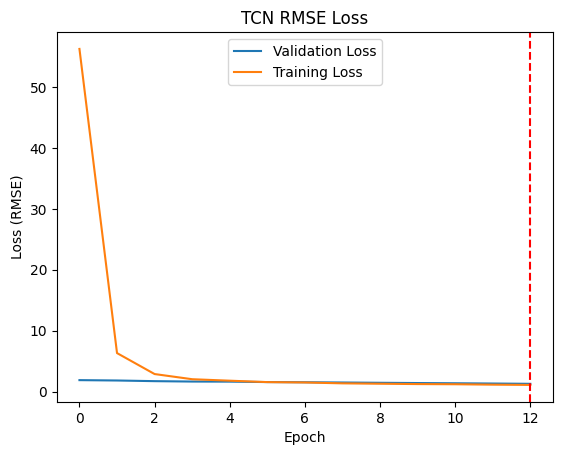

In [33]:
# Plot loss
import matplotlib.pyplot as plt
plt.plot(validation_losses, label="Validation Loss")
plt.plot(losses, label="Training Loss")
plt.title("TCN RMSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.legend()
# Highlight minimum validation loss
min_loss = min(validation_losses)
min_loss_index = validation_losses.index(min_loss)
plt.axvline(min_loss_index, color='r', linestyle='--')

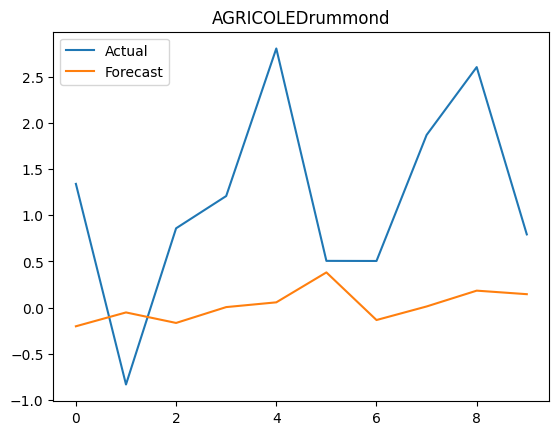

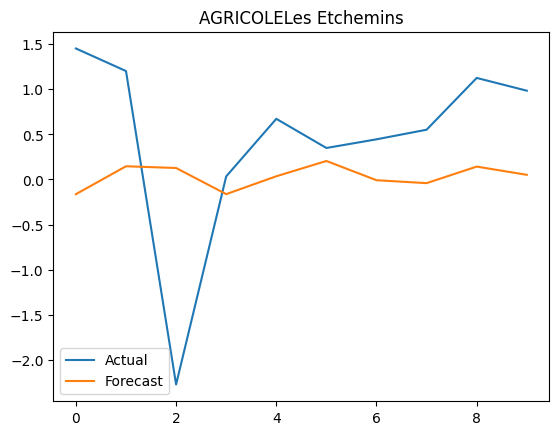

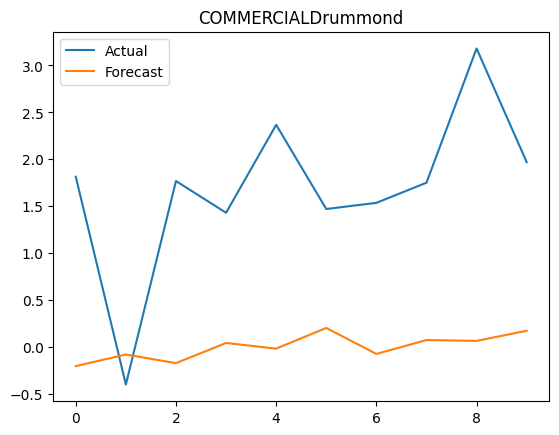

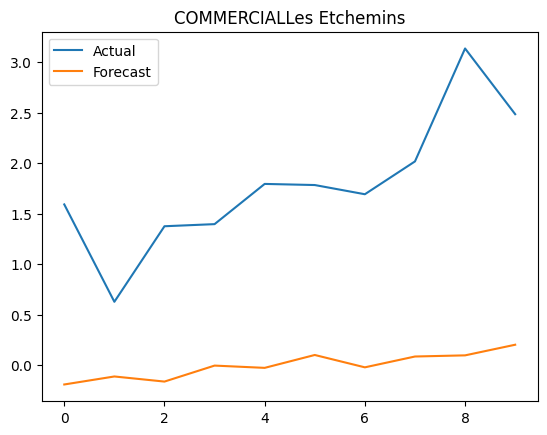

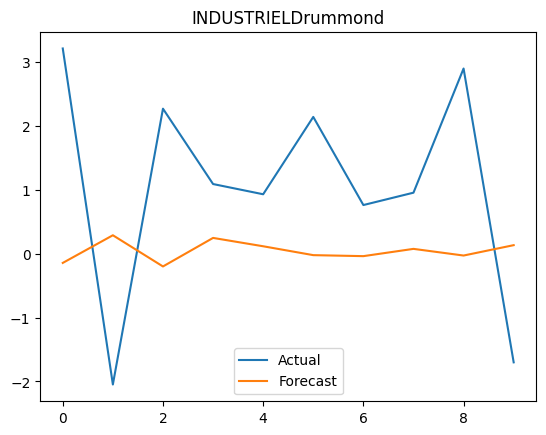

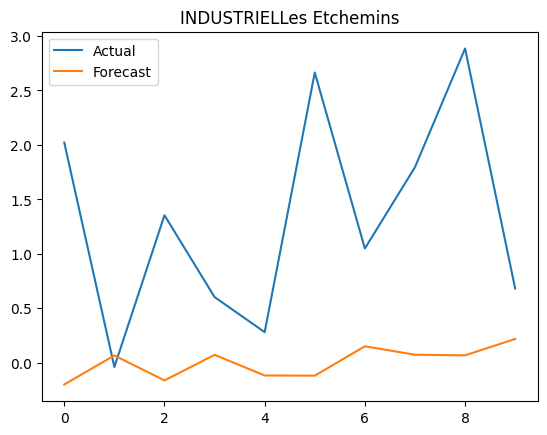

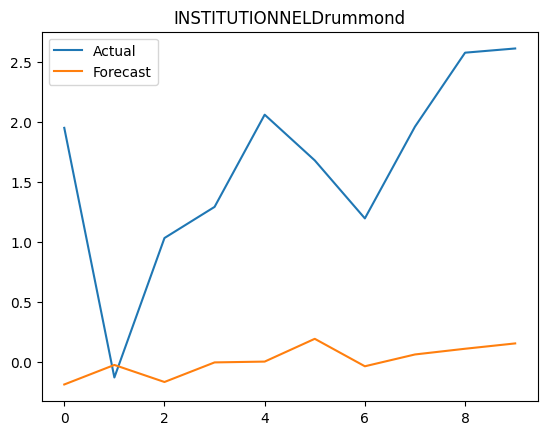

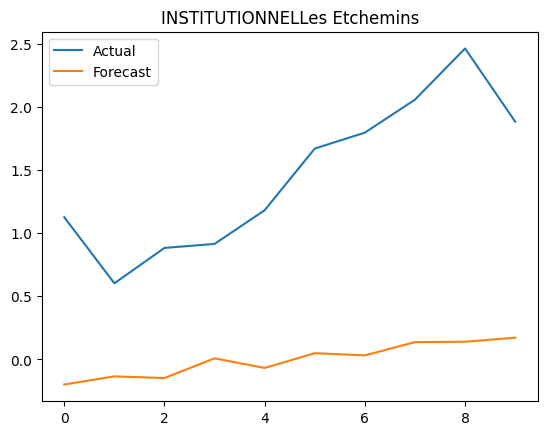

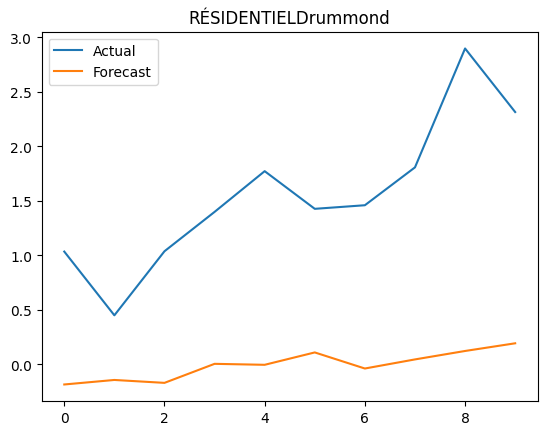

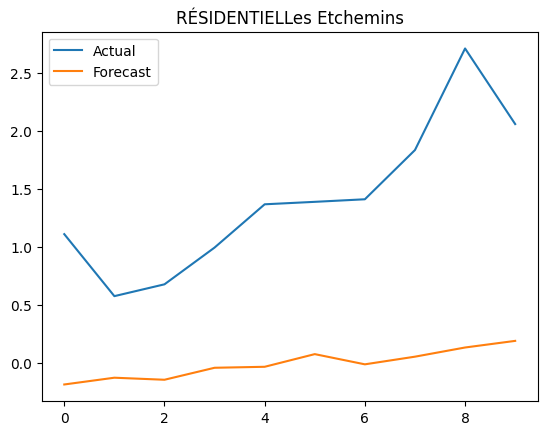

In [34]:
# Test 

mrcs = ["Drummond", "Les Etchemins"]
sectors = df["sector"].unique()
sector_mrcs = [f"{sector}{mrc}" for sector in sectors for mrc in mrcs]

errors = []
with torch.no_grad():
    for sector_mrc in sector_mrcs:
        batch, kwh_scalers, temp_scalers, starting_levels = get_n_sequences([sector_mrc], train=False, test=True)
        batch = batch.permute(0, 2, 1)
        X = batch[:, :-1, :]
        y = batch[:, -1, :]
        output = model(X)
        y = y + torch.tensor(starting_levels).float().unsqueeze(1)

        # y = kwh_scalers[0].inverse_transform(y)
        # output = kwh_scalers[0].inverse_transform(output.squeeze(1))
        plt.plot(y.squeeze())
        plt.plot(output.squeeze())
        plt.legend(["Actual", "Forecast"])
        plt.title(sector_mrc)
        plt.show()
        # print(y)
        # print(output)
        # print(consumptions)


In [87]:
y

array([[ -33577.0003922 , -148832.00334681,  -77088.99781934,
         -69581.00221587,   16805.00044011,  -14388.00034982,
          13328.00017451,  104599.00410311,  149368.99953039,
          65901.0018059 ]])

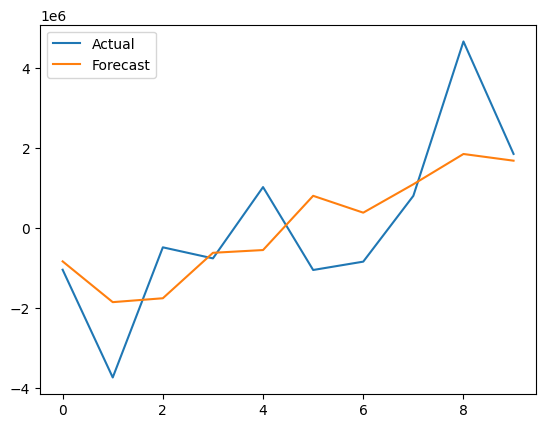

In [90]:
# Plot forecast vs actual
import matplotlib.pyplot as plt
plt.plot(y.squeeze())
plt.plot(output.squeeze())
plt.legend(["Actual", "Forecast"])
plt.show()

In [45]:
mapes = validate(model)

In [90]:
import numpy as np
np.mean(mapes)

np.float64(0.3015086724911373)

In [84]:
df.to_csv("dataset_standardized.csv")